# Zillow Data Anaysis 
### By Fermin F. Garcia IV

# Overview: 
    

# Projecgt Goals:
- Construct an ML Regression model that predict propery tax assessed values of Single Family Properties using attributes of the properties
- Find the key drivers of property value for single family properties
- Make recommendations on what works and what doesn't?

## Imports 

In [4]:
import wrangle_zillow as w 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Aquire and Prep our data 

In [6]:
train, validate, test = w.split(w.prepare(w.aquire_zillow_data()))

y_train = train['tax_valuedollar_cnt']
X_train = train.drop(['tax_valuedollar_cnt'], axis=1)

# Split the validation data into target and feature variables
y_validate = validate['tax_valuedollar_cnt']
X_validate = validate.drop(['tax_valuedollar_cnt'], axis=1)

# Split the test data into target and feature variables
y_test = test['tax_valuedollar_cnt']
X_test = test.drop(['tax_valuedollar_cnt'], axis=1)

# Let's explore our data and see what story it tells 

In [8]:
round(X_train.describe(),2)

,bedrooms,bathrooms,calculated_finished_squarefeet,year_built,tax_amount,la_county_ca,orange_county_ca,ventura_county_ca
count,22400.00,22400.00,22400.00,22400.00,22400.00,22400.00,22400.00,22400.00
mean,3.28,2.19,1793.78,1960.58,5152.90,0.67,0.26,0.07
std,0.87,0.86,746.11,21.99,4855.81,0.47,0.44,0.26
min,1.00,1.00,504.00,1885.00,61.82,0.00,0.00,0.00
25%,3.00,2.00,1258.00,1949.00,2493.00,0.00,0.00,0.00
50%,3.00,2.00,1611.00,1958.00,4079.07,1.00,0.00,0.00
75%,4.00,3.00,2163.00,1975.00,6241.83,1.00,1.00,0.00
max,6.00,6.50,4795.00,2016.00,141871.54,1.00,1.00,1.00


In [11]:
X_train.dtypes

bedrooms                          float64
bathrooms                         float64
calculated_finished_squarefeet    float64
year_built                          int64
tax_amount                        float64
la_county_ca                        uint8
orange_county_ca                    uint8
ventura_county_ca                   uint8
dtype: object

# What is the correlated here? 

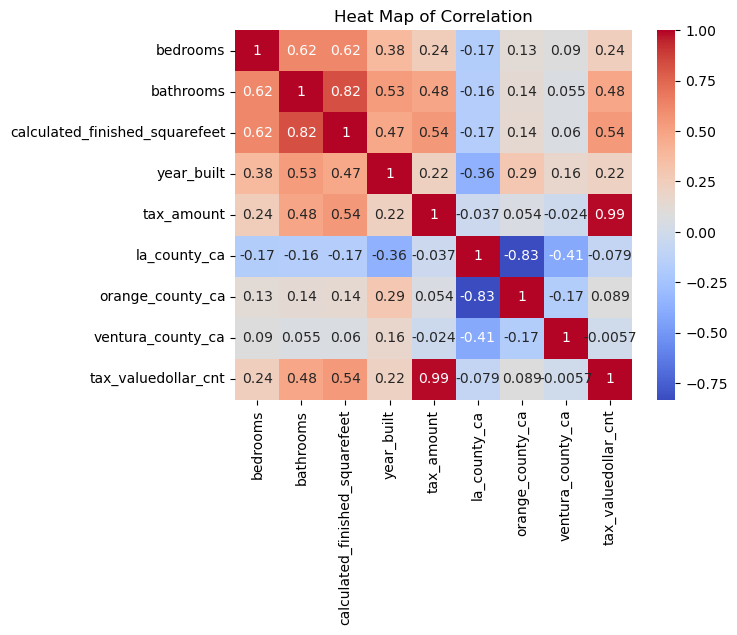

In [12]:
# First we make a 
corr_matrix = pd.concat([X_train, y_train], axis=1).corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heat Map of Correlation')
plt.show()

### Heat map anaysis:
- We made a correlation matrix and applied it to a heat map. 
- The darker red a square is, the stronger the correlation.
- Some areas of interest are 'calculated_finished_squarefeet', 'bathrooms', 'tax_amount'


# What is our Hypothesis? 

## H$_0$: There is no correlation between bathrooms and and the tax_valuedollar_cnt 

## H$_a$: There is a correlation between bathrooms and and the tax_valuedollar_cnt

sns.violinplot(x='bathrooms', y=y_train, data=X_train)
plt.show()

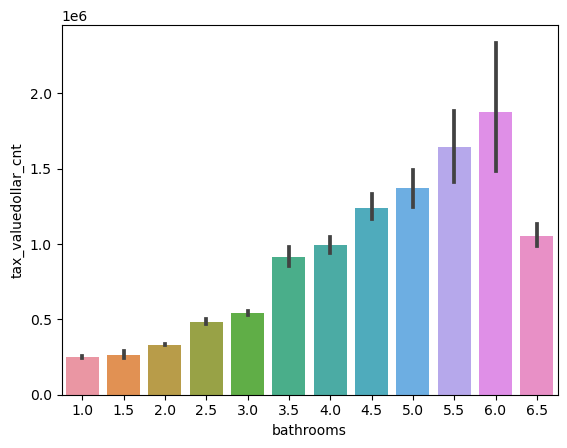

In [40]:
sns.barplot(x='bathrooms', y=y_train, data=X_train)
plt.show()

In [48]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Baseline Model

In [49]:
# Lets set some base lines
y_train_mean = y_train.mean()

# Create an array of the same shape as y_test with the mean value
y_pred_baseline = np.full_like(y_test, y_train_mean)

# Calculate the SSE
baseline_sse = np.sum(np.square(y_test - y_pred_baseline))
print("Baseline SSE:", baseline_sse)

# Calculate the MSE
baseline_mse = baseline_sse / len(y_test)
print("Baseline MSE:", baseline_mse)

# Calculate the RMSE
baseline_rmse = np.sqrt(baseline_mse)
print("Baseline RMSE:", baseline_rmse)

Baseline SSE: 1481667585831300.5
Baseline MSE: 185208448228.91257
Baseline RMSE: 430358.51127741457


# Baseline Model Metrics

    Baseline SSE: 1481667585831300.5
    Baseline MSE: 185208448228.91257
    Baseline RMSE: 430358.51127741457

# OLS Model

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Instantiate the model
ols_model = LinearRegression()

# Fit the model on the training data
ols_model.fit(X_train_scaled, y_train)

# Make predictions on the validation data
ols_y_pred = ols_model.predict(X_validate_scaled)

# Calculate the mean squared error
ols_mse = mean_squared_error(y_validate, ols_y_pred)

# Calculate the root mean squared error
ols_rmse = ols_mse ** 0.5

# Calculate the sum of squared errors
ols_sse = ((y_validate - ols_y_pred) ** 2).sum()

# Calculate the error delta
ols_error_delta = ols_sse - baseline_sse

# Create a dataframe with the model metrics
ols_model_metrics = pd.DataFrame({
    'metric': ['SSE', 'MSE', 'RMSE'],
    'model_error': [ols_sse, ols_mse, ols_rmse],
    'error_delta': [ols_error_delta, ols_mse - baseline_mse, ols_rmse - baseline_rmse]
})

# Round the values in the dataframe
ols_model_metrics = ols_model_metrics.round(3)

# Print the dataframe
print(ols_model_metrics)


  metric   model_error   error_delta
0    SSE  5.500952e+13 -1.426658e+15
1    MSE  5.730159e+09 -1.794783e+11
2   RMSE  7.569781e+04 -3.546607e+05


# Linear Rgression OLS (metrics)

      metric   model_error   error_delta
    0    SSE  5.500952e+13 -1.426658e+15
    1    MSE  5.730159e+09 -1.794783e+11
    2   RMSE  7.569781e+04 -3.546607e+05

# Lasso Model

In [ ]:
from sklearn.linear_model import LassoLars
from sklearn.metrics import mean_squared_error

# Instantiate the model
lasso_model = LassoLars()

# Fit the model on the training data
lasso_model.fit(X_train, y_train)

# Make predictions on the validation data
lasso_y_pred = lasso_model.predict(X_validate)

# Calculate the mean squared error
lasso_mse = mean_squared_error(y_validate, lasso_y_pred)

# Calculate the root mean squared error
lasso_rmse = lasso_mse ** 0.5

# Calculate the sum of squared errors
lasso_sse = ((y_validate - lasso_y_pred) ** 2).sum()

# Calculate the error delta
lasso_error_delta = lasso_sse - baseline_sse

# Create a dataframe with the model metrics
lasso_model_metrics = pd.DataFrame({
    'metric': ['SSE', 'MSE', 'RMSE'],
    'model_error': [lasso_sse, lasso_mse, lasso_rmse],
    'error_delta': [lasso_error_delta, lasso_mse - baseline_mse, lasso_rmse - baseline_rmse]
})

# Round the values in the dataframe
lasso_model_metrics = lasso_model_metrics.round(3)

# Print the dataframe
print(lasso_model_metrics)


# Lasso Metrics

      metric   model_error   error_delta
    0    SSE  5.502991e+13 -1.426638e+15
    1    MSE  5.732282e+09 -1.794762e+11
    2   RMSE  7.571183e+04 -3.546467e+05

    SSE: Linear Regression OLS model performed better.
    MSE: Linear Regression OLS model performed better.
    RMSE: Linear Regression OLS model performed better.

# Summary of Report 

# ** Next Steps:**

- Collect more  data on the areal events

- Collect more data on demographics (i.g income, material status, education, career type )

- Develop machine learning models with higher accuracy (lower RMSE) with the prosed data and make better predictions.

- Continue to collect on future data ,so we can help our model better predict the tax value dollar cnt or 'Sale Price'